# Independent Beta Count (Syntax-Context)

## 0a. Coding Info

* **Corpus**
    * Brown
    * McRae Norms
* **Parser**
    * SpaCy
* **Algorithm**
    * Count-based Indep. Beta Bayesian Updating (Erk 2016)
* **Evaluation**
    * Precision @1/@5
    * Mean Average Precision (MAP) https://www.youtube.com/watch?v=pM6DJ0ZZee0&index=12&list=PLBv09BD7ez_6nqE9YU9bQXpjJ5jJ1Kgr9

## 0b. Packages

In [33]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from itertools import chain
from __future__ import division
from sklearn.metrics import average_precision_score

## 0c. Input Preparation

In [4]:
import cPickle

In [5]:
concepts,cpt2ft,cpt2ftprob,features = cPickle.load(open("/Users/jacobsw/Desktop/UNIV/FALL_2016/LIN389C_RSCH_COMPLING/BAYESIAN/DATA/MCRAE/qmr.p",'rb'))
triples = cPickle.load(open("/Users/jacobsw/Desktop/UNIV/FALL_2016/LIN389C_RSCH_COMPLING/BAYESIAN/DATA/BROWN/brown_triples.p",'rb'))

In [6]:
len(concepts)==len(set(concepts))

True

In [7]:
f2i = {f:i for i,f in enumerate(features)}

In [8]:
cpt2ftprob_dic = defaultdict(dict)
for cpt in concepts:
    cpt2ftprob_dic[cpt] = {ft:ftprob for ft,ftprob in zip(cpt2ft[cpt],cpt2ftprob[cpt])}

In [9]:
cpt2ftprob_dic['book']

{'found_in_libraries': 0.34999999999999998,
 'found_in_schools': 0.34999999999999998,
 'found_on_shelves': 0.94999999999999996,
 'has_a_hard_cover': 0.34999999999999998,
 'has_a_soft_cover': 0.34999999999999998,
 'has_authors': 1.0,
 'has_information': 1.0,
 'has_page_numbers': 1.0,
 'has_pages': 1.0,
 'has_pictures': 0.34999999999999998,
 'has_words_in_it': 1.0,
 'made_of_paper': 0.94999999999999996,
 'tells_stories': 0.34999999999999998,
 'used_by_reading': 1.0,
 'used_for_acquiring/storing_knowledge': 1.0,
 'used_for_learning': 0.34999999999999998}

## 0d. Disctinctiveness

In [36]:
def distinctiveness_stats(concepts, features, cpt2ft):
    ft2numcpt = defaultdict(int)
    ft2distinct = defaultdict(float)
    for cpt in concepts:
        fts = cpt2ft[cpt]
        for ft in fts:
            ft2numcpt[ft] += 1
    dist_list = [1/ft2numcpt[ft] for ft in ft2numcpt.iterkeys()]
    for ft in ft2numcpt.iterkeys():
        ft2distinct[ft] = 1/ft2numcpt[ft] 
    print "X: Distinctiveness | Y: # Feature having corresponding Distinctiveness"
    print "Mean: %.2f | Standard Deviation: %.2f" % (np.mean(dist_list), np.std(dist_list))
    print "Min: %d| Max: %d" % (min(dist_list), max(dist_list))
    plt.hist(dist_list,bins=100)
    plt.show()
    return ft2distinct

X: Distinctiveness | Y: # Feature having corresponding Distinctiveness
Mean: 0.77 | Standard Deviation: 0.33
Min: 0| Max: 1


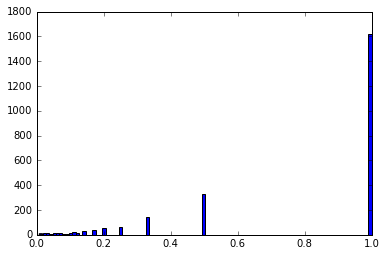

In [37]:
ft2distinct = distinctiveness_stats(concepts, features, cpt2ft)

In [43]:
print ft2distinct['an_animal']
print ft2distinct['eats_mice']
print ft2distinct['used_for_wiping_feet']

0.010101010101
0.333333333333
1.0


## 0f. General Purpose Functions

In [10]:
def normalize(arr):
    return arr / arr.sum()

def partition(l, k):
    """ args: list, # partitions.
        returns: a list of k partitions.
    """
    k = max(1, k)
    chunk_size = len(l)//k
    if len(l)%k==0:
        return [l[i:i+chunk_size] for i in xrange(0, len(l), chunk_size)]
    return [l[i:i+chunk_size] if idx<k-1 else l[i:] for idx,i in enumerate(xrange(0, len(l), chunk_size))][:-1]

## I. Preprocessing

### A. Mappings

* Verb-Role $\mapsto$ Concept List/Set Mapping
* Concept $\mapsto$ Verb-Role List/Set Mapping

In [11]:
def preproc_mapping(concepts, triples):
    """ args: concepts, features, concept->feature mapping, concept->P(feature) mapping, dependency triples.
        returns: verb-role->concept-set mapping.
    """
    concepts_set = set(concepts) # for fast lookup.
    vr2c = defaultdict(set)
    c2vr = defaultdict(list)
    for word,dep,head in triples:
        if word in concepts_set and (dep=='nsubj' or dep=='dobj'):
            vr2c[head+'-'+dep].add(word)
            c2vr[word].append(head+'-'+dep)
    return vr2c, c2vr

In [12]:
vr2c, c2vr = preproc_mapping(concepts, triples)

In [13]:
vrs = vr2c.keys() # global verb-role pair indexing.
vr2i = {vr:i for i,vr in enumerate(vrs)}
print len(vrs)

955


In [14]:
concepts_subset = c2vr.keys() # ORDER DOESN'T MATTER
print len(concepts_subset)

311


### B. Train-Test Split

In [15]:
def preproc_split(concepts, k=5):
    """ arg: concepts, cv numbers.
        returns: k .8/.2 train-test splits.
    """
    # random.shuffle(concepts) # TODO: messing up with the indexing. will fix later.
    concept_chunks = partition(concepts, k)
    train_test_splits = []
    for i in range(k):
        train_cpts = list(chain.from_iterable([concept_chunk for j,concept_chunk in enumerate(concept_chunks)
                                               if j!=i]))
        test_cpts = concept_chunks[i]
        train_test_splits.append((train_cpts,test_cpts))
    return train_test_splits

In [16]:
train_test_splits = preproc_split(concepts_subset)

In [17]:
print train_test_splits[0][0]; print
print train_test_splits[0][1]; print
print len(train_test_splits)

[u'wagon', u'bat', u'clam', u'peacock', u'tongs', u'level', u'cigar', u'bracelet', u'gun', u'pencil', u'swimsuit', u'axe', u'bag', u'microscope', u'hatchet', u'gloves', u'subway', u'rock', u'nightingale', u'mouse', u'garage', u'tray', u'trailer', u'lantern', u'turtle', u'butterfly', u'fence', u'cage', u'house', u'duck', u'crown', u'worm', u'lion', u'cellar', u'mirror', u'candle', u'marble', u'hammer', u'chicken', u'whip', u'barn', u'moth', u'peg', u'closet', u'clock', u'kettle', u'fox', u'revolver', u'vest', u'mug', u'stool', u'bureau', u'pistol', u'slingshot', u'knife', u'tent', u'cockroach', u'sheep', u'pepper', u'hose', u'umbrella', u'camel', u'pear', u'corn', u'cart', u'cork', u'guitar', u'spoon', u'grasshopper', u'sink', u'key', u'goldfish', u'comb', u'grenade', u'card', u'box', u'stone', u'drum', u'jet', u'cow', u'saddle', u'jeep', u'walrus', u'biscuit', u'anchor', u'magazine', u'cod', u'falcon', u'ox', u'coin', u'buckle', u'scarf', u'clamp', u'shovel', u'apple', u'spear', u'toil

** ================== NB: The objects above this line are globally referenced!! ==================**

## II. Learning

In [18]:
def to_ft_vec(cpt):
    """ args: a concept
        returns: a len(features) array of feature probs in numpy array.
    """
    return np.array([cpt2ftprob_dic[cpt][ft] if ft in cpt2ftprob_dic[cpt] else 0 for ft in features],dtype=np.float32)

def learn_stc(train_cpts):
    
    vr2ftabs = defaultdict(lambda : np.array([[1,1] for _ in range(len(features))],dtype=np.float32))
    for vr in vrs:
        cpts = list(vr2c[vr])
        for cpt in filter(lambda cpt:cpt in train_cpts, cpts):
            cpt_ftprobs = to_ft_vec(cpt)
            for f_i in range(len(features)):
                if cpt_ftprobs[f_i]!=0:
                    vr2ftabs[vr][f_i] = [vr2ftabs[vr][f_i][0]+cpt_ftprobs[f_i], 
                                         vr2ftabs[vr][f_i][1]+(1-cpt_ftprobs[f_i])]
                else:
                    vr2ftabs[vr][f_i] = [vr2ftabs[vr][f_i][0], 
                                         vr2ftabs[vr][f_i][1]+1]                    
    return vr2ftabs

# def learn_bin(train_cpts):

#     vr2ftabs = defaultdict(lambda : np.array([[1,1] for _ in range(len(features))],dtype=np.float32))
#     for vr in vrs:
#         cpts = list(vr2c[vr])
#         for cpt in filter(lambda cpt:cpt in train_cpts, cpts):
#             cpt_ftprobs = to_ft_vec(cpt)
#             for f_i in range(len(features)):
#                 if cpt_ftprobs[f_i]!=0:
#                     vr2ftabs[vr][f_i] = [vr2ftabs[vr][f_i][0]+1, vr2ftabs[vr][f_i][0]] # if pos, alpha+1
#                 else:
#                     vr2ftabs[vr][f_i] = [vr2ftabs[vr][f_i][0], vr2ftabs[vr][f_i][1]+1] # if neg, beta+1
#     return vr2ftabs

In [19]:
# t = learn_bin(train_test_splits[0][0])

In [199]:
# for i,(a,b) in enumerate(t['feed-dobj']):
#     if a!=1:
#         print a,b,features[i]

In [20]:
# t = learn_stc(train_test_splits[0][0])

In [21]:
# for i,(a,b) in enumerate(t['feed-dobj']):
#     print a,b,features[i]

## III. Inference

In [22]:
def infer_stc(train_test_splits):
    
    cpt2ftabs = defaultdict(lambda : np.array([[1,1] for _ in range(len(features))],dtype=np.float32))
    for train_cpts,test_cpts in train_test_splits:
        vr2ftabs = learn_stc(train_cpts)
        for cpt in test_cpts:
            ftabs = np.array([[1,1] for _ in range(len(features))],dtype=np.float32)
            for vr in c2vr[cpt]:
                vr_ftabs = vr2ftabs[vr]
                for f_i in range(len(features)):
                    ftabs[f_i] = [ftabs[f_i][0]+vr_ftabs[f_i][0],
                                  ftabs[f_i][1]+vr_ftabs[f_i][1]]
            cpt2ftabs[cpt] = ftabs
    return cpt2ftabs

# def infer_bin(train_test_splits):
    
#     cpt2ftabs = defaultdict(lambda : np.array([[1,1] for _ in range(len(features))],dtype=np.float32))
#     for train_cpts,test_cpts in train_test_splits:
#         vr2ftabs = learn_bin(train_cpts)
#         for cpt in test_cpts:
#             ftabs = np.array([[1,1] for _ in range(len(features))],dtype=np.float32)
#             for vr in c2vr[cpt]:
#                 vr_ftabs = vr2ftabs[vr]
#                 for f_i in range(len(features)):
#                     if not (vr_ftabs[f_i][0]==1 and vr_ftabs[f_i][1]==1): # means there's evidence at this feature.
#                         ftabs[f_i] = [ftabs[f_i][0]+vr_ftabs[f_i][0],
#                                       ftabs[f_i][1]+vr_ftabs[f_i][1]]                       
#             cpt2ftabs[cpt] = ftabs
#     return cpt2ftabs

In [23]:
%%time
cpt2ftabs_stc = infer_stc(train_test_splits)

CPU times: user 2min 21s, sys: 1.1 s, total: 2min 22s
Wall time: 2min 22s


In [24]:
# %%time
# cpt2ftabs_bin = infer_bin(train_test_splits)

In [206]:
# for i,(a,b) in enumerate(cpt2ftabs_bin['cat']):
#     if a>b:
#         print a,b, a/b, features[i]

In [200]:
# for i,(a,b) in enumerate(cpt2ftabs_bin['cat']):
#     if a<b:
#         print a,b, a/b, features[i]

In [201]:
# for i,(a,b) in enumerate(cpt2ftabs_stc['cat']):
#     if a>b:
#         print a,b, a/b, features[i]

In [202]:
# for i,(a,b) in enumerate(cpt2ftabs_stc['cat']):
#     if a<b:
#         print a,b, a/b, features[i]

In [44]:
def to_probdist(cpt2ftabs):
    cpt2ftdist = defaultdict(lambda : np.zeros(len(features)))
    for cpt in cpt2ftabs.iterkeys():
        cpt2ftdist[cpt] = np.array([cpt2ftabs[cpt][f_i][0]/(cpt2ftabs[cpt][f_i][0]+cpt2ftabs[cpt][f_i][1])
                                    for f_i in range(len(features))])
    return cpt2ftdist

# def to_probdist2(cpt2ftabs): # weight predictions by distinctiveness
#     cpt2ftdist = defaultdict(lambda : np.zeros(len(features)))
#     for cpt in cpt2ftabs.iterkeys():
#         cpt2ftdist[cpt] = np.array([(cpt2ftabs[cpt][f_i][0]/(cpt2ftabs[cpt][f_i][0]+cpt2ftabs[cpt][f_i][1])) *\
#                                     ft2distinct[ft]
#                                     for f_i,ft in enumerate(features)])
#     return cpt2ftdist

In [26]:
%%time
cpt2ftdist_stc = to_probdist(cpt2ftabs_stc)

In [58]:
# cpt2ftdist_stc2 = to_probdist2(cpt2ftabs_stc)

In [209]:
# cpt2ftdist_bin = to_probdist(cpt2ftabs_bin)

## IV. Evaluation

In [85]:
def evaluate_prec(cpt2ftdist):
    precs_1, precs_5, precs_10, precs_20, precs_50 = [], [], [], [], []
    for cpt in cpt2ftdist.iterkeys():
        true_fts = cpt2ft[cpt]
        pred_fts = map(lambda f_i:features[f_i], np.argsort(cpt2ftdist[cpt])[::-1])
        precs_1.append(1 if pred_fts[0] in true_fts else 0)
        precs_5.append(sum(1 if pred_ft in true_fts else 0 for pred_ft in pred_fts[:5]) / 5)
        precs_10.append(sum(1 if pred_ft in true_fts else 0 for pred_ft in pred_fts[:10]) / 10)
        precs_20.append(sum(1 if pred_ft in true_fts else 0 for pred_ft in pred_fts[:20]) / 20)
        precs_50.append(sum(1 if pred_ft in true_fts else 0 for pred_ft in pred_fts[:50]) / 50)
    print "Average Prec @1: %.6f%%" % (np.mean(precs_1)*100)
    print "Average Prec @5: %.6f%%" % (np.mean(precs_5)*100)
    print "Average Prec @10: %.6f%%" % (np.mean(precs_10)*100)
    print "Average Prec @20: %.6f%%" % (np.mean(precs_20)*100)
    print "Average Prec @50: %.6f%%" % (np.mean(precs_50)*100)

In [28]:
def evaluate_map(cpt2ftdist):
    aps = []
    for cpt in cpt2ftdist.iterkeys():
        true_ftbin = np.array([1 if ft in cpt2ft[cpt] else 0 for ft in features])
        pred_ftdist = normalize(cpt2ftdist[cpt])
        aps.append(average_precision_score(true_ftbin, pred_ftdist))
    print "MAP: %.6f%%" % (np.mean(aps)*100)

In [47]:
evaluate_prec(cpt2ftdist_stc)
evaluate_map(cpt2ftdist_stc)

Average Prec @1: 23.472669%
Average Prec @5: 16.141479%
MAP: 12.103578%


In [59]:
# evaluate_prec(cpt2ftdist_stc2)
# evaluate_map(cpt2ftdist_stc2)
# Average Prec @1: 0.000000%
# Average Prec @5: 0.000000%
# MAP: 1.144657%

In [30]:
# evaluate_prec(cpt2ftdist_bin)
# evaluate_map(cpt2ftdist_bin)

## V. Revision & Error Analysis

### A. Experiment: Learn only from informative verb-role pairs (unmask distinctive features)

In [52]:
sorted(map(lambda (vr,c): (vr,len(c)), vr2c.items()),key=lambda x:x[1],reverse=True)

[(u'be-nsubj', 100),
 (u'have-dobj', 53),
 (u'take-dobj', 33),
 (u'put-dobj', 33),
 (u'have-nsubj', 30),
 (u'get-dobj', 29),
 (u'use-dobj', 25),
 (u'come-nsubj', 23),
 (u'leave-dobj', 19),
 (u'carry-dobj', 18),
 (u'turn-dobj', 18),
 (u'hold-dobj', 17),
 (u'see-dobj', 17),
 (u'go-nsubj', 17),
 (u'drop-dobj', 15),
 (u'make-dobj', 14),
 (u'bring-dobj', 14),
 (u'wear-dobj', 13),
 (u'find-dobj', 13),
 (u'give-dobj', 13),
 (u'pick-dobj', 13),
 (u'buy-dobj', 13),
 (u'do-nsubj', 12),
 (u'build-dobj', 12),
 (u'keep-dobj', 12),
 (u'begin-nsubj', 11),
 (u'move-nsubj', 11),
 (u'enter-dobj', 11),
 (u'play-dobj', 10),
 (u'offer-dobj', 10),
 (u'open-dobj', 10),
 (u'stand-nsubj', 10),
 (u'fill-dobj', 10),
 (u'need-dobj', 9),
 (u'watch-dobj', 9),
 (u'send-dobj', 9),
 (u'pull-dobj', 9),
 (u'give-nsubj', 8),
 (u'grab-dobj', 8),
 (u'add-dobj', 8),
 (u'lay-dobj', 8),
 (u'take-nsubj', 8),
 (u'fall-nsubj', 8),
 (u'look-nsubj', 8),
 (u'run-nsubj', 8),
 (u'hand-dobj', 8),
 (u'do-dobj', 7),
 (u'throw-dobj', 7),

In [54]:
vr2numc = {vr:len_c for vr,len_c in map(lambda (vr,c): (vr,len(c)), vr2c.items())}

In [56]:
print vr2numc['be-nsubj']

100


In [64]:
def infer_stc2(train_test_splits, info_cut=5):
    
    cpt2ftabs = defaultdict(lambda : np.array([[1,1] for _ in range(len(features))],dtype=np.float32))
    for train_cpts,test_cpts in train_test_splits:
        vr2ftabs = learn_stc(train_cpts)
        for cpt in test_cpts:
            ftabs = np.array([[1,1] for _ in range(len(features))],dtype=np.float32)
            for vr in c2vr[cpt]:
                
                if vr2numc[vr] > info_cut: continue # ONLY UPDATE ON INFORMATIVE VRS
                
                vr_ftabs = vr2ftabs[vr]
                for f_i in range(len(features)):
                    ftabs[f_i] = [ftabs[f_i][0]+vr_ftabs[f_i][0],
                                  ftabs[f_i][1]+vr_ftabs[f_i][1]]
            cpt2ftabs[cpt] = ftabs
    return cpt2ftabs

** a. Info_cut = 1 **

In [87]:
%%time
cpt2ftabs_stc2 = infer_stc2(train_test_splits, info_cut=1)

CPU times: user 2min 1s, sys: 1 s, total: 2min 2s
Wall time: 2min 2s


In [88]:
%%time
cpt2ftdist_stc2 = to_probdist(cpt2ftabs_stc2)

CPU times: user 736 ms, sys: 63.8 ms, total: 800 ms
Wall time: 749 ms


In [89]:
evaluate_prec(cpt2ftdist_stc2)
evaluate_map(cpt2ftdist_stc2)

Average Prec @1: 0.321543%
Average Prec @5: 0.192926%
Average Prec @10: 0.418006%
Average Prec @20: 0.627010%
Average Prec @50: 0.430868%
MAP: 50.281714%


** Info_cut = 3 **

In [90]:
%%time
cpt2ftabs_stc2 = infer_stc2(train_test_splits, info_cut=3)

CPU times: user 2min 6s, sys: 954 ms, total: 2min 7s
Wall time: 2min 6s


In [91]:
%%time
cpt2ftdist_stc2 = to_probdist(cpt2ftabs_stc2)

CPU times: user 720 ms, sys: 43.7 ms, total: 764 ms
Wall time: 729 ms


In [92]:
evaluate_prec(cpt2ftdist_stc2)
evaluate_map(cpt2ftdist_stc2)

Average Prec @1: 8.038585%
Average Prec @5: 4.694534%
Average Prec @10: 4.405145%
Average Prec @20: 3.456592%
Average Prec @50: 1.980707%
MAP: 28.075794%


** c. Info_cut = 5 **

In [93]:
%%time
cpt2ftabs_stc2 = infer_stc2(train_test_splits)

CPU times: user 2min 9s, sys: 961 ms, total: 2min 10s
Wall time: 2min 9s


In [94]:
%%time
cpt2ftdist_stc2 = to_probdist(cpt2ftabs_stc2)

CPU times: user 730 ms, sys: 28.8 ms, total: 759 ms
Wall time: 737 ms


In [95]:
evaluate_prec(cpt2ftdist_stc2)
evaluate_map(cpt2ftdist_stc2)

Average Prec @1: 9.003215%
Average Prec @5: 6.237942%
Average Prec @10: 5.627010%
Average Prec @20: 4.581994%
Average Prec @50: 2.655949%
MAP: 22.680469%


** d. Info_cut = 10 **

In [96]:
%%time
cpt2ftabs_stc2 = infer_stc2(train_test_splits, info_cut=10)

CPU times: user 2min 6s, sys: 1.18 s, total: 2min 7s
Wall time: 2min 6s


In [97]:
%%time
cpt2ftdist_stc2 = to_probdist(cpt2ftabs_stc2)

CPU times: user 745 ms, sys: 31.8 ms, total: 776 ms
Wall time: 751 ms


In [98]:
evaluate_prec(cpt2ftdist_stc2)
evaluate_map(cpt2ftdist_stc2)

Average Prec @1: 14.469453%
Average Prec @5: 10.225080%
Average Prec @10: 8.135048%
Average Prec @20: 5.964630%
Average Prec @50: 3.581994%
MAP: 16.725461%


** f. Info_cut = 15 **

In [99]:
%%time
cpt2ftabs_stc2 = infer_stc2(train_test_splits, info_cut=15)

CPU times: user 2min 8s, sys: 1.12 s, total: 2min 9s
Wall time: 2min 9s


In [100]:
%%time
cpt2ftdist_stc2 = to_probdist(cpt2ftabs_stc2)

CPU times: user 749 ms, sys: 22.1 ms, total: 771 ms
Wall time: 755 ms


In [101]:
evaluate_prec(cpt2ftdist_stc2)
evaluate_map(cpt2ftdist_stc2)

Average Prec @1: 18.649518%
Average Prec @5: 12.282958%
Average Prec @10: 9.710611%
Average Prec @20: 6.961415%
Average Prec @50: 4.167203%
MAP: 15.225408%


** g. Info_cut = 20 **

In [71]:
%%time
cpt2ftabs_stc2 = infer_stc2(train_test_splits, info_cut=20)

CPU times: user 2min 15s, sys: 1.06 s, total: 2min 16s
Wall time: 2min 15s


In [72]:
%%time
cpt2ftdist_stc2 = to_probdist(cpt2ftabs_stc2)

CPU times: user 758 ms, sys: 43 ms, total: 801 ms
Wall time: 768 ms


In [86]:
evaluate_prec(cpt2ftdist_stc2)
evaluate_map(cpt2ftdist_stc2)

Average Prec @1: 8.038585%
Average Prec @5: 4.694534%
Average Prec @10: 4.405145%
Average Prec @20: 3.456592%
Average Prec @50: 1.980707%
MAP: 28.075794%
